# Classification Experiment using Supervised ML

This notebook is meant to prepare a data file and conduct machine learning experiments using traditional supervised leraning models (random forest, decision tree, SVM, etc.).  The models will be used for binary classification.

The data file will be a CSV that is updated with a sequence group column and a label (target) column for a classification problem using machine learning models to predict the target.  The "sequence_group" column will be used to group sequences that are related to each other.  The label column will be used to indicate the target value for each sequence.  The data file will be used to train and test machine learning models to predict the target value for new sequences.

The steps outlined here will build upon one another and should be run sequentially so that the final data file will be processed using a number of different models.

I highly recommend the use of a GPU for this experiment.  The use of a GPU will greatly reduce the time it takes to train the models.

## File Preperation

The basic steps for getting a file ready for the ML expermient are:

1. Load the data file
1. Filter the columns of interest which would include the features and the target (also known as the label)
1. Normalize the data
1. Create the target column lagged by one period
1. Split the data, build, compile, train & evaluate the model

The data file has been created using NinjaTrader 8 and is a CSV file.  The rows represent renko bars.  The other features represent the indicators which were used with defaults.  

**Important**: The indicators used here are not good features for this problem because they are being used on a chart type and at a granularity that is not typical for the indicator.  The indicators are being used to demonstrate the process of preparing the data file and conducting the machine learning experiments.  The utility which was used to create the data file is the "Exporter" strategy which I authored in my NinjaTrader repository on GitHub.  I have included a sample data file in the /data directory using NQ 30 tick renko bars.

**Note**: Any indicator which is a "price" type indicator has been converted to be a percentage difference from the "close" price of the related bar. This is to make the indicator values more consistent across different instruments and time frames.

### Data File Assumptions

- The data file will be a CSV
- The data file will have a header row
- The data file will have a column that contains the target value and it must be a binary value
- The data file will be in sequential chronological order
- The data file will have a column that contains a date and time value to aide sequence grouping
- The data file is already cleansed with regard to missing values and outliers


**Steps 1 & 2: Load the Data File and Filter the Columns of Interest**
- Update the file paths
- Update the column names for the features and the target

In [10]:
# STEP 1 & 2
# Declare the input & output file paths, the columns to write and the target column
# perform the imports
import pandas as pd

file_in = '../data_prod/NQ0324_30TICK_07-16_20240203175932.csv'
file_tmp = '../tmp/NQ0324_30TICK_07-16_20240203175932.csv'
file_out = '../data_prod/NQ0324_30TICK_07-16_20240203175932.csv'
file_training = '../data_prod/NQ0324_30TICK_07-16_20240203175932.csv'
file_testing = '../data_prod/NQ0324_30TICK_07-16_20240203175932.csv'
tmp_dir = '../tmp'

columns_to_write = [
    'date',
    'higherclose',
    'reversal',
    'trendsequence',
    'adl',
    'adx',
    'adxr',
    'apz_lower',
    'apz_upper',
    'aroonoscillator',
    'atr',
    'bollinger_lower',
    'bollinger_middle',
    'bollinger_upper',
    'bop',
    'camarilla_r1',
    'camarilla_r2',
    'camarilla_r3',
    'camarilla_r4',
    'camarilla_s1',
    'camarilla_s2',
    'camarilla_s3',
    'camarilla_s4',
    'cci',
    'chaikinmoneyflow',
    'chaikinoscillator',
    'chaikinvolatility',
    'choppinessindex',
    'cmo',
    'currentday_open',
    'currentday_low',
    'currentday_high',
    'disparityindex',
    'dm_diplus',
    'dm_diminus',
    'dmi',
    'dmindex',
    'donchian_lower',
    'donchian_mean',
    'donchian_upper',
    'doublestochastics_k',
    'easeofmovement',
    'fibonacci_pp',
    'fibonacci_r1',
    'fibonacci_r2',
    'fibonacci_r3',
    'fibonacci_s1',
    'fibonacci_s2',
    'fibonacci_s3',
    'fisherstransform',
    'fosc',
    'kama',
    'keltner_lower',
    'keltner_mean',
    'keltner_upper',
    'linreg',
    'linregintercept',
    'linregslope',
    'macd',
    'macd_avg',
    'macd_diff',
    'mama_default',
    'mama_kama',
    'mfi',
    'momentum',
    'moneyflowoscillator',
    'orderflowcumulativedelta_deltaopen',
    'orderflowcumulativedelta_deltaclose',
    'orderflowcumulativedelta_deltahigh',
    'orderflowcumulativedelta_deltalow',
    'orderflowvwap_vwap',
    'orderflowvwap_s1_lower',
    'orderflowvwap_s1_higher',
    'orderflowvwap_s2_lower',
    'orderflowvwap_s2_higher',
    'orderflowvwap_s3_lower',
    'orderflowvwap_s3_higher',
    'parabolic_sar',
    'pfe',
    'ppo',
    'priceoscillator',
    'psychologicalline',
    'rsquared',
    'relativevigorindex',
    'rind',
    'roc',
    'rsi',
    'rsi_avg',
    'rss',
    'rvi',
    'stddev',
    'stochrsi',
    'stochastics_d',
    'stochastics_k',
    'stochasticsfast_d',
    'stochasticsfast_k',
    'trix',
    'trix_signal',
    'tsf',
    'tsi',
    'ultimateoscillator',
    'vortex_viplus',
    'vortex_viminus',
    'volma',
    'volume_oscillator',
    'vroc',
    'williamsr',
    'wisemanawesomeoscillator',
    'woodiescci',
    'woodiescci_turbo',
    'woodiespivot_pp',
    'woodiespivot_r1',
    'woodiespivot_r2',
    'woodiespivot_s1',
    'woodiespivot_s2'
    ]

group_helper = 'date' # This is the column that will be used to group the data and must be a datetime column in the format '%Y-%m-%d %H:%M:%S.%f'
target_column = 'higherclose' # This is the column that will be used as the target column for the model and must be a binary column

# Load the data from the input CSV file into a pandas dataframe
df = pd.read_csv(file_in)

# Convert 'date' column to datetime format for easier manipulation
df[group_helper] = pd.to_datetime(df[group_helper], format='%Y-%m-%d %H:%M:%S.%f')

# Save the modified dataframe with only the specified columns to a new CSV file
#df.to_csv(file_tmp, index=False, columns=columns_to_write)
df[target_column] = df[target_column].astype(int)
df_filtered = df[columns_to_write]
#df_filtered.to_csv(file_tmp, index=False)

**Step 3: Normalize the Data**

This step will use the MinMaxScaler to normalize the data.  The MinMaxScaler will scale the data to a range of 0 to 1.

In [11]:
from sklearn.preprocessing import RobustScaler

# List of features to exclude from normalization
features_to_exclude = [group_helper, target_column]

# Dynamically select features to normalize (all features except the ones to exclude)
features_to_normalize = [col for col in df_filtered.columns if col not in features_to_exclude]

# Initialize the Scaler
scaler = RobustScaler() # AKA Z-score normalization, better at handling outliers

# Fit the scaler to the data (for the features to be normalized)
scaler.fit(df_filtered[features_to_normalize])

# Transform the data using the fitted scaler
df_normalized = df_filtered.copy()  # Create a copy of the DataFrame to keep the original data intact
df_normalized[features_to_normalize] = scaler.transform(df_filtered[features_to_normalize])

#df_normalized.to_csv(file_out, index=False)

**Step 4: Create the Target Column Lagged by One Period**

This step will use the shift function to look ahead at the target_column to pull the value from the future onto the prior record.  This will be the "future_target_column" of interest for predictions.  Unlike RNN models, traditional ML models require the data to be in a tabular format.  This means that the data must be in a table with rows and columns (2D).

In [12]:
# STEP 4
from datetime import datetime

# Create a new column for the future target value (shifted by 1 row)
df_normalized[f'future_{target_column}'] = df_normalized[target_column].shift(-1).astype('Int8')

# Remove any rows with NaN values in the future target column & drop the 'date' column
df_normalized.dropna(subset=[f'future_{target_column}'], inplace=True)
df_normalized = df_normalized.drop(columns=['date'])

# Write the final DataFrame to a new CSV file
print(f"Record Count: {len(df_normalized)}")
#df_normalized.to_csv(file_tmp, index=False)

Record Count: 20748


/tmp/ipykernel_18573/2645305511.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_normalized[f'future_{target_column}'] = df_normalized[target_column].shift(-1).astype('Int8')


**Step 5: Split the Data, Build, Compile, Train & Evaluate the Model**

/home/bbecker/proj/ml-sandbox/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.6782
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      2578
         1.0       0.68      0.68      0.68      2609

    accuracy                           0.68      5187
   macro avg       0.68      0.68      0.68      5187
weighted avg       0.68      0.68      0.68      5187

Confusion Matrix:
[[1747  831]
 [ 838 1771]]


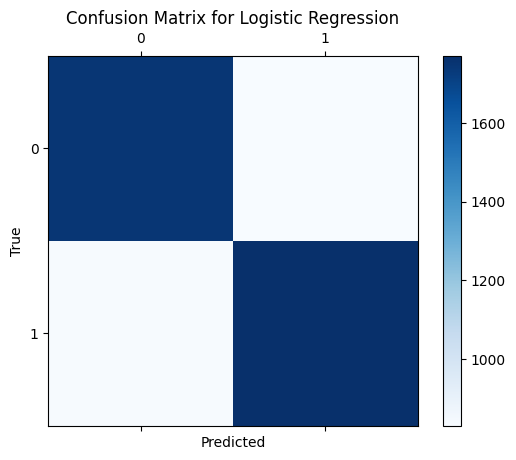

Model: Ridge Classifier
Accuracy: 0.6786
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      2578
         1.0       0.68      0.68      0.68      2609

    accuracy                           0.68      5187
   macro avg       0.68      0.68      0.68      5187
weighted avg       0.68      0.68      0.68      5187

Confusion Matrix:
[[1750  828]
 [ 839 1770]]


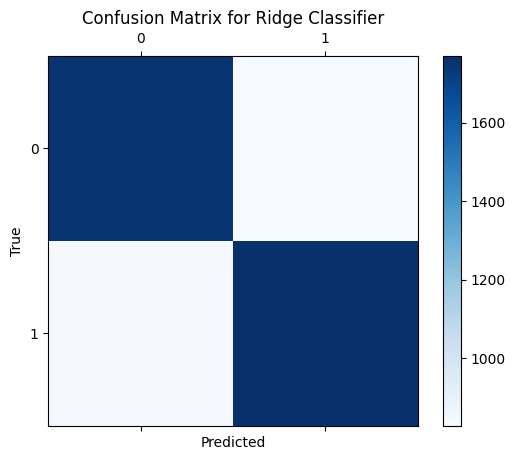

Model: Support Vector Classification
Accuracy: 0.6790
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      2578
         1.0       0.68      0.68      0.68      2609

    accuracy                           0.68      5187
   macro avg       0.68      0.68      0.68      5187
weighted avg       0.68      0.68      0.68      5187

Confusion Matrix:
[[1747  831]
 [ 834 1775]]


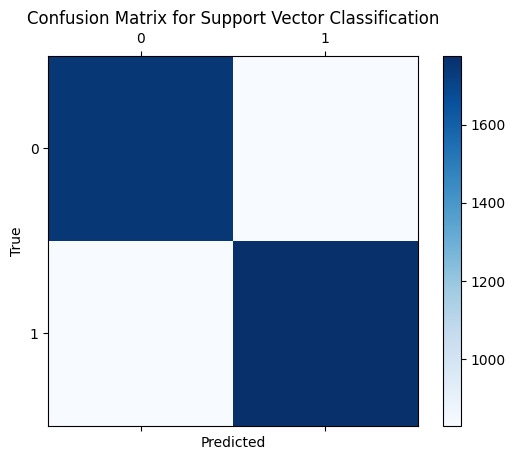

/home/bbecker/proj/ml-sandbox/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model: Linear Support Vector Classification
Accuracy: 0.6773
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68      2578
         1.0       0.68      0.67      0.68      2609

    accuracy                           0.68      5187
   macro avg       0.68      0.68      0.68      5187
weighted avg       0.68      0.68      0.68      5187

Confusion Matrix:
[[1764  814]
 [ 860 1749]]


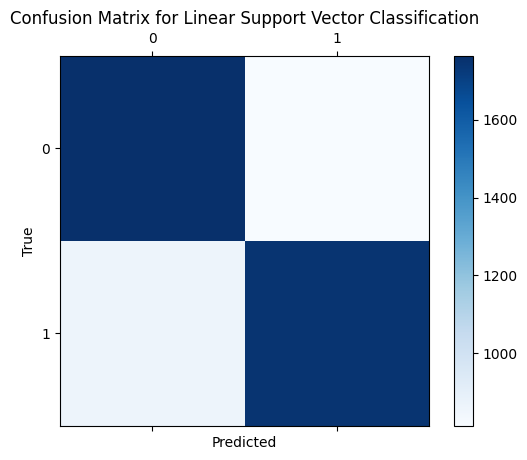

Model: Decision Tree
Accuracy: 0.5649
Classification Report:
              precision    recall  f1-score   support

         0.0       0.56      0.57      0.56      2578
         1.0       0.57      0.56      0.56      2609

    accuracy                           0.56      5187
   macro avg       0.56      0.56      0.56      5187
weighted avg       0.56      0.56      0.56      5187

Confusion Matrix:
[[1465 1113]
 [1144 1465]]


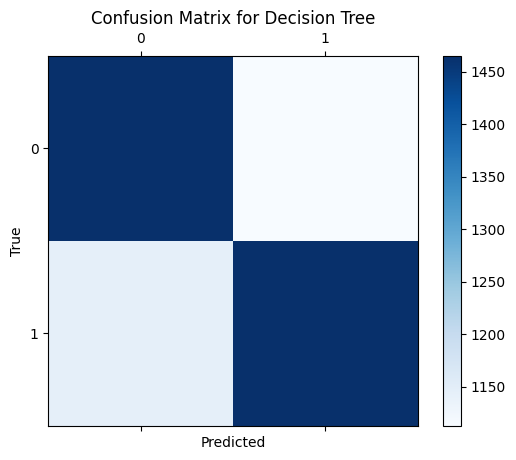

Model: Random Forest
Accuracy: 0.6615
Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66      2578
         1.0       0.66      0.66      0.66      2609

    accuracy                           0.66      5187
   macro avg       0.66      0.66      0.66      5187
weighted avg       0.66      0.66      0.66      5187

Confusion Matrix:
[[1710  868]
 [ 888 1721]]


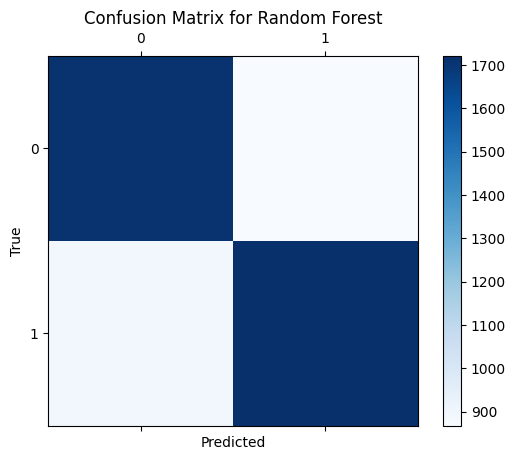

Model: K-Neighbors Classifier
Accuracy: 0.6077
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.60      0.60      2578
         1.0       0.61      0.61      0.61      2609

    accuracy                           0.61      5187
   macro avg       0.61      0.61      0.61      5187
weighted avg       0.61      0.61      0.61      5187

Confusion Matrix:
[[1550 1028]
 [1007 1602]]


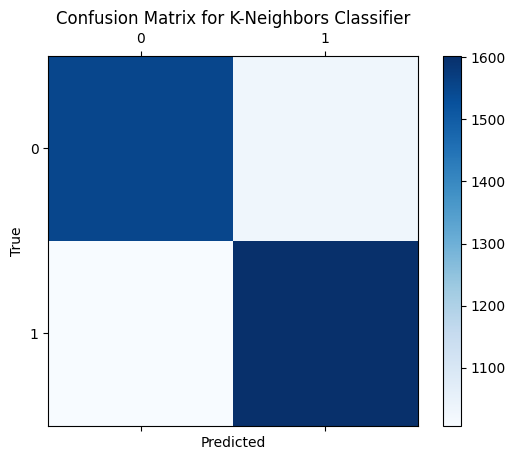

Model: Gaussian Naive Bayes
Accuracy: 0.6027
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.63      0.61      2578
         1.0       0.61      0.57      0.59      2609

    accuracy                           0.60      5187
   macro avg       0.60      0.60      0.60      5187
weighted avg       0.60      0.60      0.60      5187

Confusion Matrix:
[[1633  945]
 [1116 1493]]


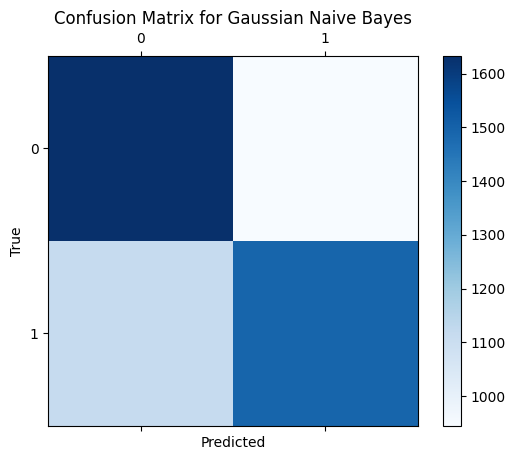

Model: Bernoulli Naive Bayes
Accuracy: 0.5946
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.60      0.59      2578
         1.0       0.60      0.59      0.59      2609

    accuracy                           0.59      5187
   macro avg       0.59      0.59      0.59      5187
weighted avg       0.59      0.59      0.59      5187

Confusion Matrix:
[[1542 1036]
 [1067 1542]]


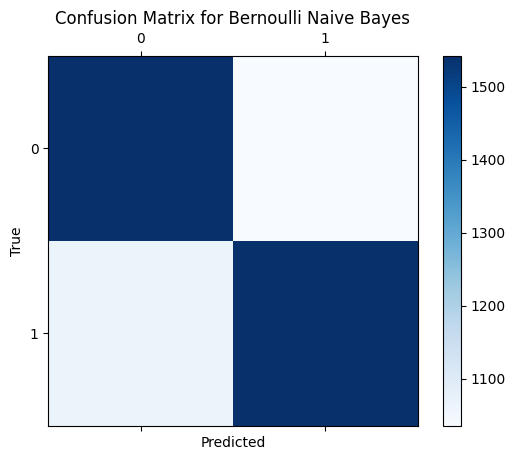

/home/bbecker/proj/ml-sandbox/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoost Classifier
Accuracy: 0.6730
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      2578
         1.0       0.68      0.67      0.67      2609

    accuracy                           0.67      5187
   macro avg       0.67      0.67      0.67      5187
weighted avg       0.67      0.67      0.67      5187

Confusion Matrix:
[[1743  835]
 [ 861 1748]]


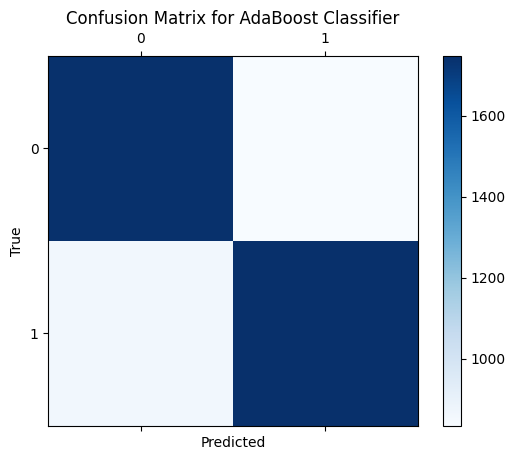

Model: Gradient Boosting Classifier
Accuracy: 0.6784
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      2578
         1.0       0.68      0.68      0.68      2609

    accuracy                           0.68      5187
   macro avg       0.68      0.68      0.68      5187
weighted avg       0.68      0.68      0.68      5187

Confusion Matrix:
[[1749  829]
 [ 839 1770]]


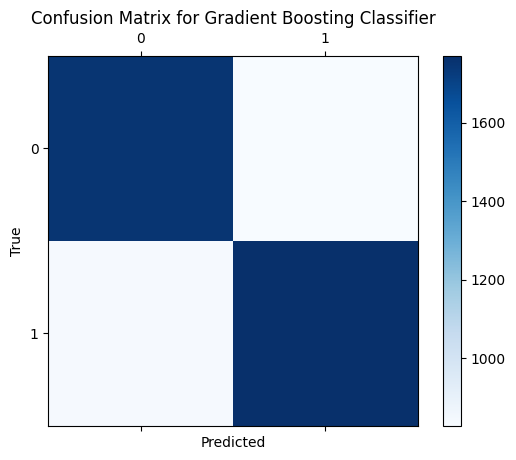

Model: Extra Trees Classifier
Accuracy: 0.6518
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65      2578
         1.0       0.66      0.65      0.65      2609

    accuracy                           0.65      5187
   macro avg       0.65      0.65      0.65      5187
weighted avg       0.65      0.65      0.65      5187

Confusion Matrix:
[[1690  888]
 [ 918 1691]]


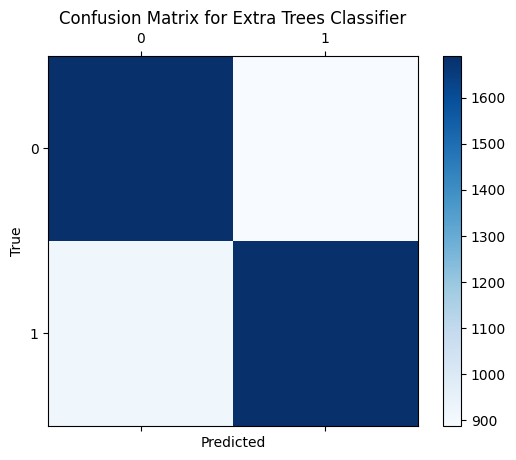

Model: Bagging Classifier
Accuracy: 0.6117
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.69      0.64      2578
         1.0       0.63      0.54      0.58      2609

    accuracy                           0.61      5187
   macro avg       0.61      0.61      0.61      5187
weighted avg       0.61      0.61      0.61      5187

Confusion Matrix:
[[1772  806]
 [1208 1401]]


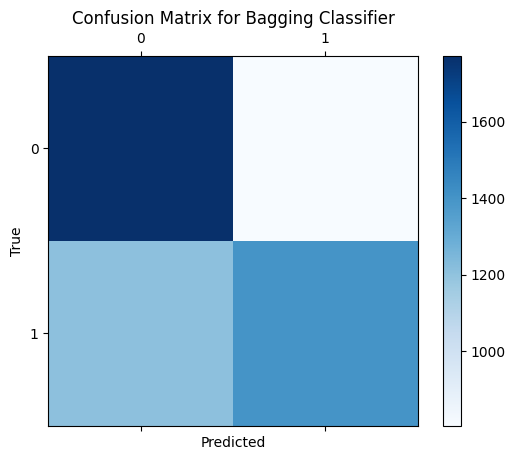

Model: SGD Classifier
Accuracy: 0.5437
Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.54      0.54      2578
         1.0       0.55      0.55      0.55      2609

    accuracy                           0.54      5187
   macro avg       0.54      0.54      0.54      5187
weighted avg       0.54      0.54      0.54      5187

Confusion Matrix:
[[1385 1193]
 [1174 1435]]


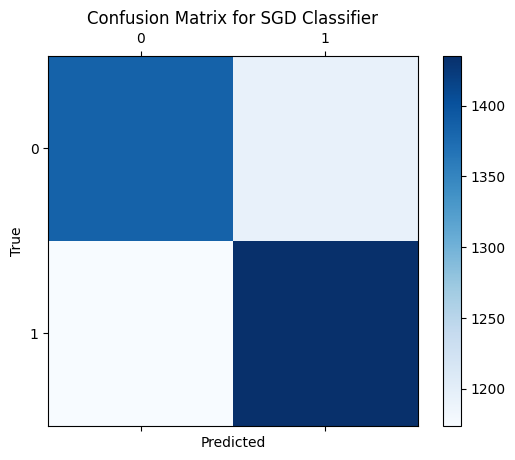

Model: XGBoost Classifier
Accuracy: 0.6312
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.62      0.62      2578
         1.0       0.63      0.65      0.64      2609

    accuracy                           0.63      5187
   macro avg       0.63      0.63      0.63      5187
weighted avg       0.63      0.63      0.63      5187

Confusion Matrix:
[[1588  990]
 [ 923 1686]]


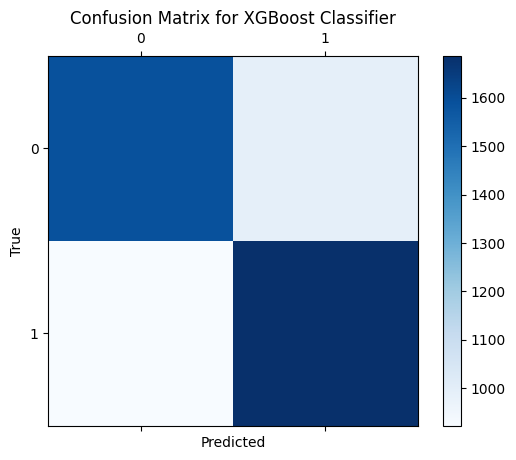

[LightGBM] [Info] Number of positive: 7867, number of negative: 7694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20509
[LightGBM] [Info] Number of data points in the train set: 15561, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505559 -> initscore=0.022236
[LightGBM] [Info] Start training from score 0.022236
Model: LightGBM Classifier
Accuracy: 0.6651
Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66      2578
         1.0       0.67      0.67      0.67      2609

    accuracy                           0.67      5187
   macro avg       0.67      0.67      0.67      5187
weighted avg       0.67      0.67      0.67      5187

Confusion Matrix:
[[1700  878]
 [ 859 1750]]


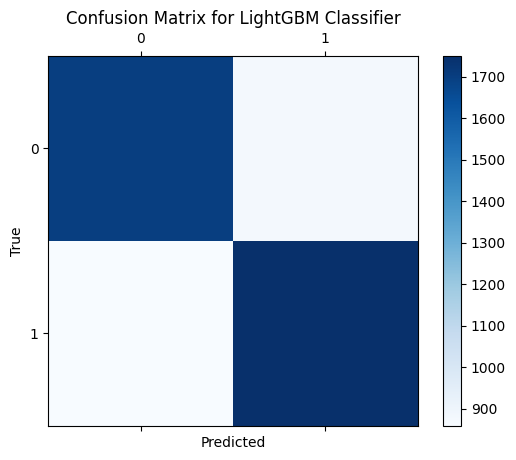

Model: CatBoost Classifier
Accuracy: 0.6707
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      2578
         1.0       0.67      0.67      0.67      2609

    accuracy                           0.67      5187
   macro avg       0.67      0.67      0.67      5187
weighted avg       0.67      0.67      0.67      5187

Confusion Matrix:
[[1730  848]
 [ 860 1749]]


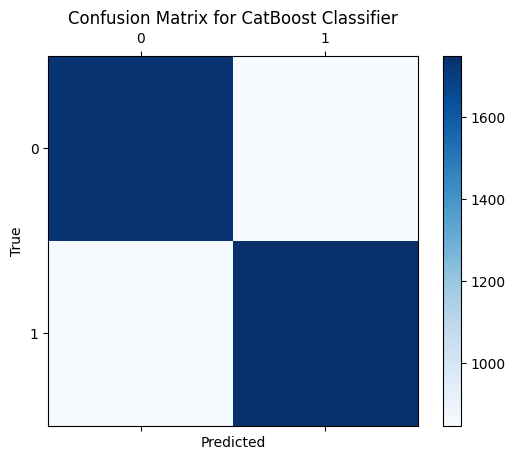

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np

future_target_column = f'future_{target_column}'

# Splitting the DataFrame into features (X) and target (y)
X = df_normalized.drop(columns=[future_target_column])  # Features
y = df_normalized[future_target_column]  # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# List of models to train and evaluate
models = [
    ('Logistic Regression', LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)),
    ('Ridge Classifier', RidgeClassifier(alpha=1.0, fit_intercept=True, copy_X=True, max_iter=None, tol=0.001, class_weight=None, solver='auto', random_state=None)),
    ('Support Vector Classification', SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)),
    ('Linear Support Vector Classification', LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)),
    ('K-Neighbors Classifier', KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)),
    ('Gaussian Naive Bayes', GaussianNB(priors=None, var_smoothing=1e-9)),
    ('Bernoulli Naive Bayes', BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)),
    ('AdaBoost Classifier', AdaBoostClassifier(estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)),
    ('Gradient Boosting Classifier', GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)),
    ('Extra Trees Classifier', ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)),
    ('Bagging Classifier', BaggingClassifier(estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)),
    ('SGD Classifier', SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, average=False)),
    ('XGBoost Classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM Classifier', LGBMClassifier()),
    ('CatBoost Classifier', CatBoostClassifier(verbose=0, train_dir=tmp_dir))
]

# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    for name, model in models:
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on testing set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        #print(f"DateTime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]}")
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(conf_matrix)
        
        # Plot confusion matrix
        fig, ax = plt.subplots()
        img = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {name}')
        fig.colorbar(img)
        ax.set_xticks(np.arange(len(np.unique(y))))
        ax.set_yticks(np.arange(len(np.unique(y))))
        # Assuming y contains integers as labels. Adjust if y contains other types.
        ax.set_xticklabels(np.unique(y))
        ax.set_yticklabels(np.unique(y))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

# Train and evaluate each model
train_and_evaluate(models, X_train, X_test, y_train, y_test)
